# Logestic regression


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Loading


In [23]:
def load_data(file_path, batch_size=64):
    data = pd.read_csv(file_path)
    Y = data['label'].values
    X = data.drop(columns=['label'], axis=1).values
    X = X / 255.0  # Normalize features

    mask = (Y == 0) | (Y == 1)  # Binary classification mask
    X_binary = X[mask]
    Y_binary = Y[mask]

    # Split the data 60-20-20
    X_train_binary, X_temp_binary, Y_train_binary, Y_temp_binary = train_test_split(
        X_binary, Y_binary, test_size=0.4, stratify=Y_binary, random_state=30
    )
    X_val_binary, X_test_binary, Y_val_binary, Y_test_binary = train_test_split(
        X_temp_binary, Y_temp_binary, test_size=0.5, stratify=Y_temp_binary, random_state=30
    )

    train_dataset = TensorDataset(torch.tensor(X_train_binary, dtype=torch.float32),
                                  torch.tensor(Y_train_binary, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val_binary, dtype=torch.float32),
                                torch.tensor(Y_val_binary, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test_binary, dtype=torch.float32),
                                 torch.tensor(Y_test_binary, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Logestic Class

In [24]:
class LogisticRegressionScratch:
    def __init__(self, input_dim=784, lr=0.01):
        self.W = torch.zeros((input_dim, 1), dtype=torch.float32)
        self.b = torch.zeros(1, dtype=torch.float32)
        self.lr = lr

    def sigmoid(self, z):
        return 1 / (1 + torch.exp(-z))

    def loss(self, y_pred, y_true):
        eps = 1e-9
        return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))

    def gradient(self, X, y_pred, y_true):
        m = y_true.shape[0]
        dw = torch.matmul(X.T, (y_pred - y_true)) 
        db = torch.sum(y_pred - y_true) 
        return dw, db

    def update_weights(self, dw, db):
        self.W -= self.lr * dw
        self.b -= self.lr * db

    def accuracy(self, y_pred, y_true):
        preds = (y_pred >= 0.5).float()
        correct = (preds == y_true).float().sum()
        return correct / y_true.shape[0]

    def train(self, train_loader, val_loader, epochs=15, patience=5):
        train_losses, val_losses, train_accs, val_accs = [], [], [], []
        best_val_loss = float('inf')
        best_weights = (self.W.clone(), self.b.clone())
        patience_counter = 0

        for epoch in range(epochs):
            # TRAIN
            epoch_train_loss = 0
            correct, total = 0, 0
            for X_batch, y_batch in train_loader:
                y_batch = y_batch.view(-1, 1).float()
                y_pred = self.sigmoid(torch.matmul(X_batch, self.W) + self.b)
                loss = self.loss(y_pred, y_batch)
                epoch_train_loss += loss.item()

                dw, db = self.gradient(X_batch, y_pred, y_batch)
                self.update_weights(dw, db)

                correct += ((y_pred >= 0.5).float() == y_batch).float().sum().item()
                total += y_batch.size(0)

            train_loss = epoch_train_loss / len(train_loader)
            train_acc = correct / total
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # VALIDATION
            epoch_val_loss = 0
            correct, total = 0, 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    y_batch = y_batch.view(-1, 1).float()
                    y_pred = self.sigmoid(torch.matmul(X_batch, self.W) + self.b)
                    loss = self.loss(y_pred, y_batch)
                    epoch_val_loss += loss.item()
                    correct += ((y_pred >= 0.5).float() == y_batch).float().sum().item()
                    total += y_batch.size(0)
            val_loss = epoch_val_loss / len(val_loader)
            val_acc = correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

            # EARLY STOPPING
            if val_loss  < best_val_loss - 1e-4:
                best_val_loss = val_loss
                best_weights = (self.W.clone(), self.b.clone())
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping at epoch {epoch+1}.")
                    break

        self.W, self.b = best_weights

        #self.plot_curves(train_losses, val_losses, train_accs, val_accs)
        return train_losses, val_losses, train_accs, val_accs

    def plot_curves(self, train_losses, val_losses, train_accs, val_accs):
        plt.figure(figsize=(12, 5))
        plt.suptitle("Training Progress of Logistic Regression", fontsize=14)
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Val Loss', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss Curves')

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Accuracy', color='blue')
        plt.plot(val_accs, label='Val Accuracy', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy Curves')
        plt.show()

    def test(self, test_loader):
        total_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_batch = y_batch.view(-1, 1).float()
                y_pred = self.sigmoid(torch.matmul(X_batch, self.W) + self.b)
                loss = self.loss(y_pred, y_batch)
                total_loss += loss.item()

                preds = (y_pred >= 0.5).float()
                correct += (preds == y_batch).float().sum().item()
                total += y_batch.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        avg_loss = total_loss / len(test_loader)
        accuracy = correct / total

        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', values_format='d')
        plt.title('Confusion Matrix (Test Set)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        print(f"\nFinal Test Loss: {avg_loss:.4f}")
        print(f"Final Test Accuracy: {accuracy*100:.2f}%")
        return avg_loss, accuracy, cm


# Train the model

Epoch 1/15 | Train Loss: 0.025771 | Val Loss: 0.014975 | Train Acc: 0.9947 | Val Acc: 0.9976
Epoch 2/15 | Train Loss: 0.009086 | Val Loss: 0.010719 | Train Acc: 0.9985 | Val Acc: 0.9986
Epoch 3/15 | Train Loss: 0.005568 | Val Loss: 0.007994 | Train Acc: 0.9988 | Val Acc: 0.9983
Epoch 4/15 | Train Loss: 0.002991 | Val Loss: 0.008139 | Train Acc: 0.9991 | Val Acc: 0.9983
Epoch 5/15 | Train Loss: 0.001849 | Val Loss: 0.009471 | Train Acc: 0.9993 | Val Acc: 0.9980
Epoch 6/15 | Train Loss: 0.001117 | Val Loss: 0.009672 | Train Acc: 0.9995 | Val Acc: 0.9980
Epoch 7/15 | Train Loss: 0.000544 | Val Loss: 0.009039 | Train Acc: 0.9999 | Val Acc: 0.9980
Epoch 8/15 | Train Loss: 0.000434 | Val Loss: 0.008272 | Train Acc: 1.0000 | Val Acc: 0.9983

Early stopping at epoch 8.


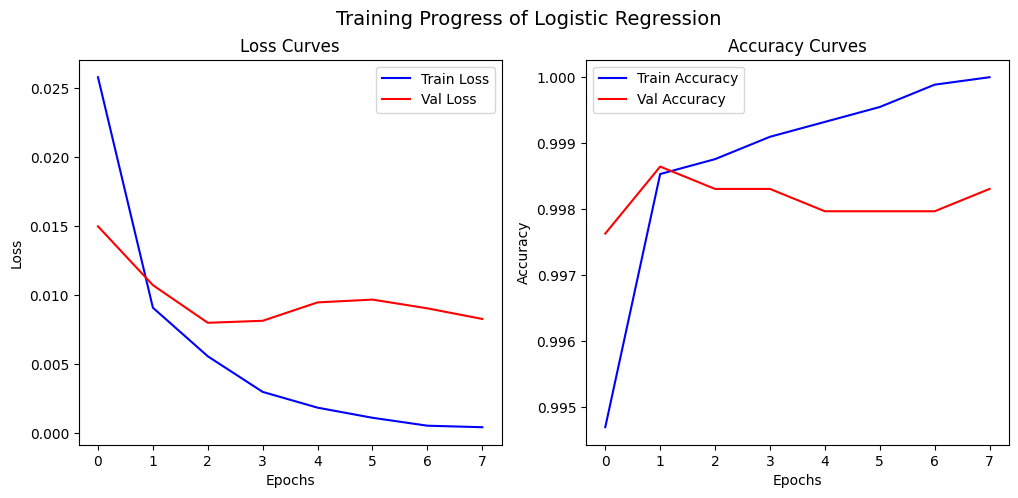

In [25]:
train_loader, val_loader, test_loader = load_data("mnist_All.csv")

# After analysis, you can test one final model
model = LogisticRegressionScratch(784, lr=0.1)
train_losses, val_losses, train_accs, val_accs = model.train(train_loader, val_loader)
model.plot_curves(train_losses, val_losses, train_accs, val_accs)


## Metrics


In [26]:
def convergence_speed(val_losses):
    best = val_losses[0]
    for i, v in enumerate(val_losses[1:], 1):
        if abs(v - best) / best < 0.001:
            return i
        best = min(best, v)
    return len(val_losses)

def stability_measure(val_losses):
    tail = val_losses[-5:] if len(val_losses) >= 5 else val_losses
    return np.std(tail)

def gradient_noise_measure(train_losses):
    return np.var(np.diff(train_losses))


Test Data

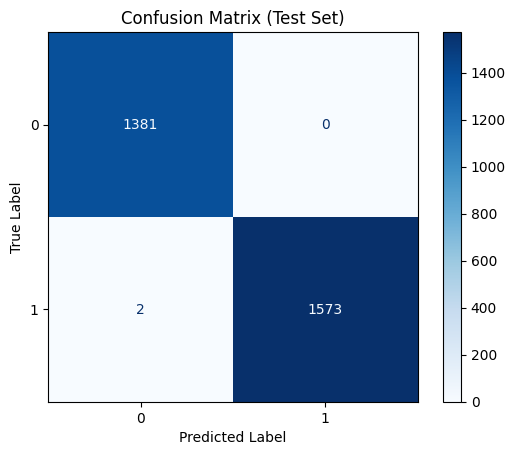


Final Test Loss: 0.0053
Final Test Accuracy: 99.93%


(0.005304144164780458,
 0.9993234100135318,
 array([[1381,    0],
        [   2, 1573]]))

In [27]:
model.test(test_loader)

this here shows that the models accuracy, the amount of correct values is very high where only2 where were mispredicted

# Learning Rate analysis

In [28]:
def run_learning_rate_analysis():
    train_loader, val_loader, _ = load_data('mnist_All.csv', batch_size=64)

    results = {}
    learning_rates = [0.001, 0.01, 0.1, 1.0]
    print("\n===== Learning Rate Analysis =====")

    for lr in learning_rates:
        print(f"\nTesting Learning Rate = {lr}")
        model = LogisticRegressionScratch(input_dim=784, lr=lr)
        train_losses, val_losses, train_acc, val_acc = model.train(train_loader, val_loader, epochs=30, patience=5)

        conv_speed = convergence_speed(val_losses)
        stability = stability_measure(val_losses)

        results[lr] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'convergence_speed': conv_speed,
            'stability': stability
        }


    # Best learning rate based on maximum validation accuracy
    best_lr = max(results, key=lambda x: max(results[x]['val_acc']))
    best_lr_acc = max(results[best_lr]['val_acc'])
    print(f"\n Best Learning Rate: {best_lr} (Val Accuracy: {best_lr_acc:.4f})")

    return results, best_lr, best_lr_acc
def plot_learning_rate_analysis(results):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 10))
    plt.suptitle('Learning Rate Analysis', fontsize=14, fontweight='bold')

    # (1) Train Loss
    plt.subplot(2, 2, 1)
    for lr, data in results.items():
        plt.plot(data['train_losses'], label=f'LR={lr}')
    plt.xlabel('Epochs'); plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (2) Validation Loss
    plt.subplot(2, 2, 2)
    for lr, data in results.items():
        plt.plot(data['val_losses'], label=f'LR={lr} (conv={data["convergence_speed"]}, stab={data["stability"]:.4f})')
    plt.xlabel('Epochs'); plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (3) Train Accuracy
    plt.subplot(2, 2, 3)
    for lr, data in results.items():
        plt.plot(data['train_acc'], label=f'LR={lr}')
    plt.xlabel('Epochs'); plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (4) Validation Accuracy
    plt.subplot(2, 2, 4)
    for lr, data in results.items():
        plt.plot(data['val_acc'], label=f'LR={lr}')
    plt.xlabel('Epochs'); plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
def analyze_results(lr_results, bs_results):
    print("\n" + "="*60)
    print(" DETAILED ANALYSIS: LEARNING RATE & BATCH SIZE")
    print("="*60)

    print("\n LEARNING RATE ANALYSIS SUMMARY:")
    print(f"{'LR':<10} {'Best Val Acc':<15} {'Conv Speed':<15} {'Stability':<15}")
    print("-"*60)
    for lr, data in lr_results.items():
        best_val_acc = max(data['val_acc'])
        conv_speed = data['convergence_speed']
        stability = data['stability']
        print(f"{lr:<10} {best_val_acc:<15.4f} {conv_speed:<15} {stability:<15.6f}")



    print("\n BATCH SIZE ANALYSIS SUMMARY:")
    print(f"{'Batch Size':<15} {'Best Val Acc':<15} {'Grad Noise':<15}")
    print("-"*50)
    for bs, data in bs_results.items():
        best_val_acc = max(data['val_acc'])
        grad_noise = data['gradient_noise']
        print(f"{bs:<15} {best_val_acc:<15.4f} {grad_noise:<15.6f}")





===== Learning Rate Analysis =====

Testing Learning Rate = 0.001
Epoch 1/30 | Train Loss: 0.068756 | Val Loss: 0.023167 | Train Acc: 0.9942 | Val Acc: 0.9976
Epoch 2/30 | Train Loss: 0.019198 | Val Loss: 0.015227 | Train Acc: 0.9973 | Val Acc: 0.9976
Epoch 3/30 | Train Loss: 0.014001 | Val Loss: 0.012254 | Train Acc: 0.9975 | Val Acc: 0.9976
Epoch 4/30 | Train Loss: 0.011589 | Val Loss: 0.010642 | Train Acc: 0.9976 | Val Acc: 0.9976
Epoch 5/30 | Train Loss: 0.010142 | Val Loss: 0.009610 | Train Acc: 0.9979 | Val Acc: 0.9976
Epoch 6/30 | Train Loss: 0.009158 | Val Loss: 0.008884 | Train Acc: 0.9980 | Val Acc: 0.9980
Epoch 7/30 | Train Loss: 0.008436 | Val Loss: 0.008341 | Train Acc: 0.9981 | Val Acc: 0.9980
Epoch 8/30 | Train Loss: 0.007878 | Val Loss: 0.007915 | Train Acc: 0.9983 | Val Acc: 0.9980
Epoch 9/30 | Train Loss: 0.007432 | Val Loss: 0.007572 | Train Acc: 0.9985 | Val Acc: 0.9980
Epoch 10/30 | Train Loss: 0.007064 | Val Loss: 0.007287 | Train Acc: 0.9986 | Val Acc: 0.9980
Ep

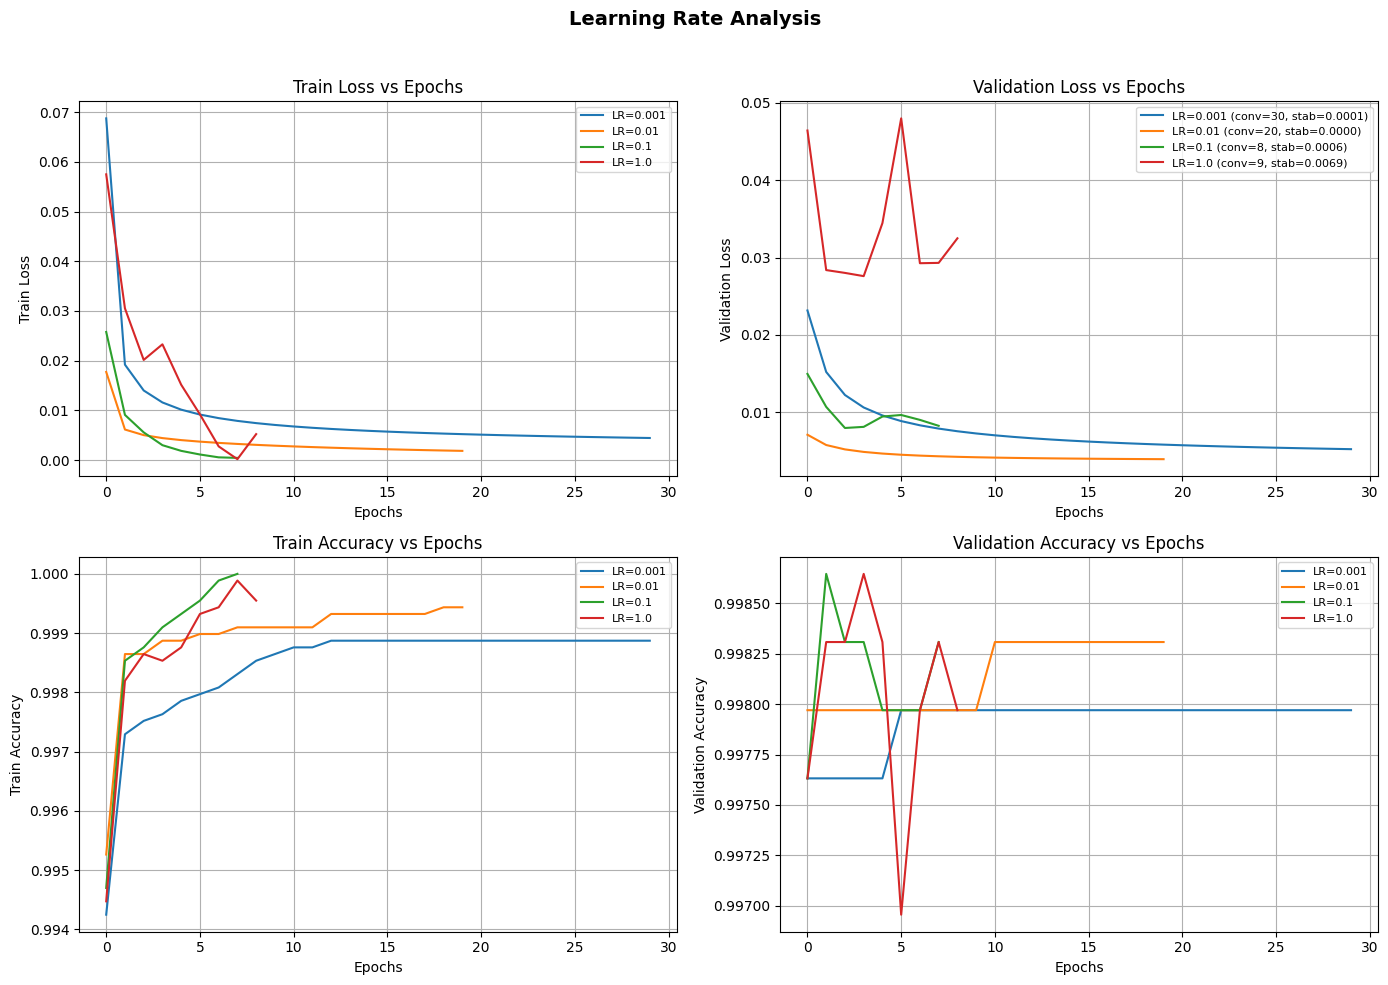

In [29]:
lr_results, best_lr, best_lr_acc = run_learning_rate_analysis()
plot_learning_rate_analysis(lr_results)

as we can see in the graph, as the learning rate increases, fluctuations in both accuracy and loss curve also increases as the gradient uodate at a larger rate

# Batch Analysis

In [30]:
def run_batch_size_analysis():
    results = {}
    batch_sizes = [16, 32, 64, 128]
    print("\n===== Batch Size Analysis =====")

    for bs in batch_sizes:
        print(f"\nTesting Batch Size = {bs}")
        train_loader, val_loader, test_loader = load_data('mnist_All.csv', batch_size=bs)

        model = LogisticRegressionScratch(input_dim=784, lr=0.01)
  

        train_losses, val_losses,  train_acc, val_acc = model.train( train_loader, val_loader, epochs=30, patience=5)

        grad_noise = gradient_noise_measure(train_losses)

        results[bs] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'gradient_noise': grad_noise
        }


    best_bs = max(results, key=lambda x: max(results[x]['val_acc']))
    best_bs_acc = max(results[best_bs]['val_acc'])
    print(f"\n Best Batch Size: {best_bs} (Val Accuracy: {best_bs_acc:.4f})")

    return results, best_bs, best_bs_acc
def plot_batch_size_analysis(results):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 10))
    plt.suptitle('Batch Size Analysis', fontsize=14, fontweight='bold')

    # (1) Train Loss
    plt.subplot(2, 2, 1)
    for bs, data in results.items():
        plt.plot(data['train_losses'], label=f'BS={bs}')
    plt.xlabel('Epochs'); plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (2) Validation Loss
    plt.subplot(2, 2, 2)
    for bs, data in results.items():
        plt.plot(data['val_losses'], label=f'BS={bs} (grad_noise={data["gradient_noise"]:.4f})')
    plt.xlabel('Epochs'); plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (3) Train Accuracy
    plt.subplot(2, 2, 3)
    for bs, data in results.items():
        plt.plot(data['train_acc'], label=f'BS={bs}')
    plt.xlabel('Epochs'); plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (4) Validation Accuracy
    plt.subplot(2, 2, 4)
    for bs, data in results.items():
        plt.plot(data['val_acc'], label=f'BS={bs}')
    plt.xlabel('Epochs'); plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


===== Batch Size Analysis =====

Testing Batch Size = 16
Epoch 1/30 | Train Loss: 0.016962 | Val Loss: 0.007229 | Train Acc: 0.9974 | Val Acc: 0.9980
Epoch 2/30 | Train Loss: 0.006194 | Val Loss: 0.005823 | Train Acc: 0.9986 | Val Acc: 0.9980
Epoch 3/30 | Train Loss: 0.005039 | Val Loss: 0.005246 | Train Acc: 0.9988 | Val Acc: 0.9980
Epoch 4/30 | Train Loss: 0.004432 | Val Loss: 0.004919 | Train Acc: 0.9989 | Val Acc: 0.9980
Epoch 5/30 | Train Loss: 0.004024 | Val Loss: 0.004705 | Train Acc: 0.9990 | Val Acc: 0.9980
Epoch 6/30 | Train Loss: 0.003714 | Val Loss: 0.004554 | Train Acc: 0.9990 | Val Acc: 0.9983
Epoch 7/30 | Train Loss: 0.003462 | Val Loss: 0.004442 | Train Acc: 0.9990 | Val Acc: 0.9983
Epoch 8/30 | Train Loss: 0.003248 | Val Loss: 0.004356 | Train Acc: 0.9990 | Val Acc: 0.9983
Epoch 9/30 | Train Loss: 0.003062 | Val Loss: 0.004288 | Train Acc: 0.9991 | Val Acc: 0.9983
Epoch 10/30 | Train Loss: 0.002896 | Val Loss: 0.004233 | Train Acc: 0.9991 | Val Acc: 0.9983
Epoch 11/30

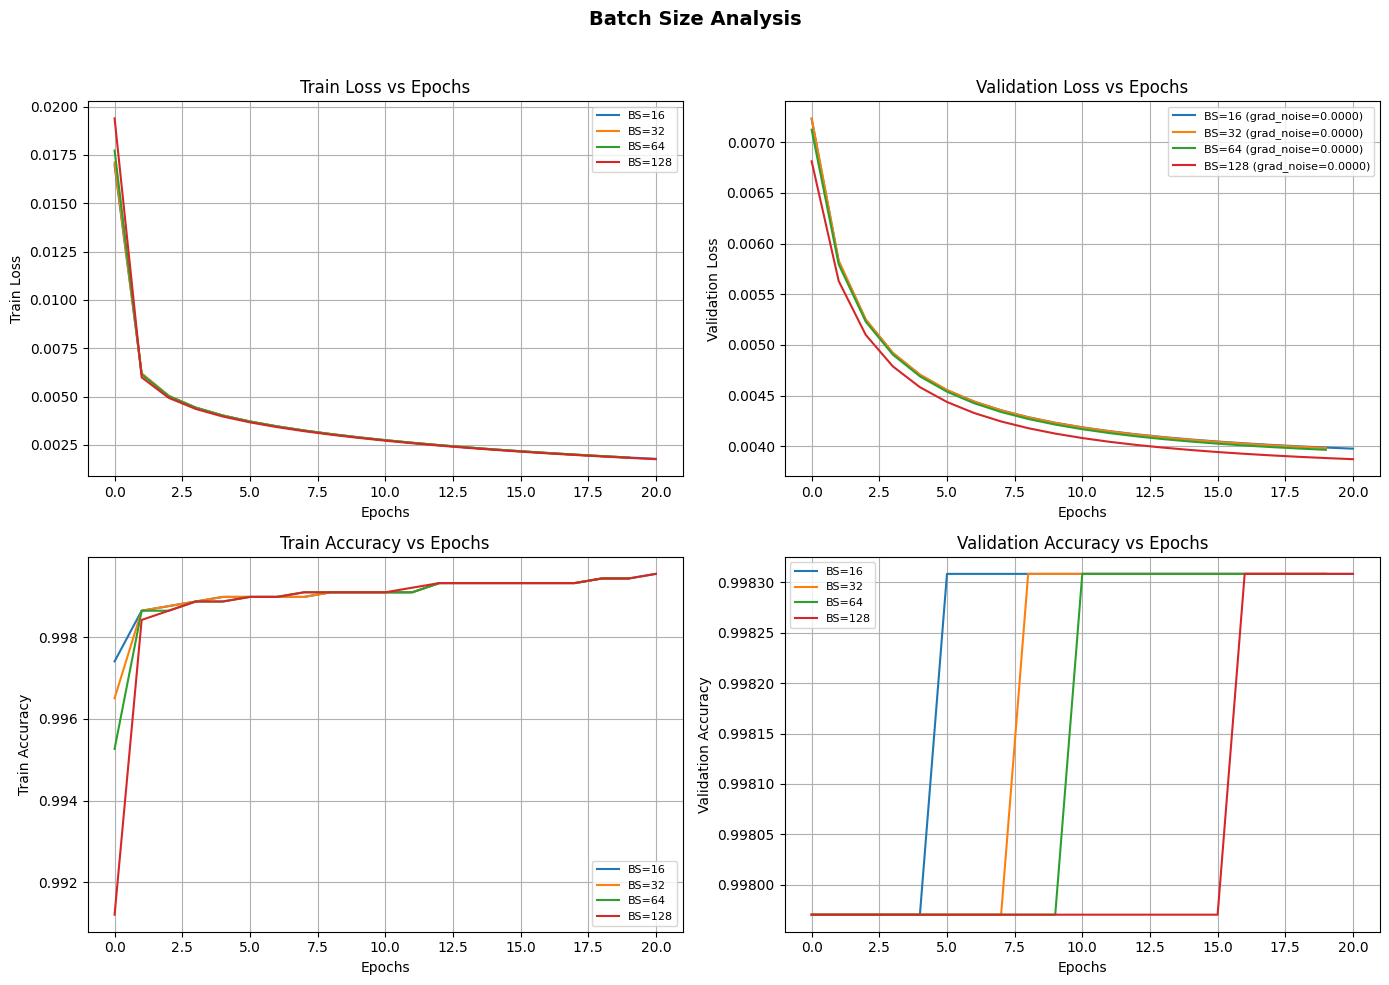

In [31]:
bs_results, best_bs, best_bs_acc = run_batch_size_analysis()
plot_batch_size_analysis(bs_results)

In [32]:
analyze_results(lr_results, bs_results)


 DETAILED ANALYSIS: LEARNING RATE & BATCH SIZE

 LEARNING RATE ANALYSIS SUMMARY:
LR         Best Val Acc    Conv Speed      Stability      
------------------------------------------------------------
0.001      0.9980          30              0.000067       
0.01       0.9983          20              0.000021       
0.1        0.9986          8               0.000619       
1.0        0.9986          9               0.006922       

 BATCH SIZE ANALYSIS SUMMARY:
Batch Size      Best Val Acc    Grad Noise     
--------------------------------------------------
16              0.9983          0.000005       
32              0.9983          0.000006       
64              0.9983          0.000006       
128             0.9983          0.000008       



    • Small LRs (0.001–0.01) converge slowly but smoothly.
    • Large LRs (e.g., 1.0) may overshoot — higher stability std means oscillation.
    • 'Convergence Speed' = epoch when val loss stabilizes.
    • Best LR usually has high val acc, low stability, and moderate conv speed.

    • Smaller batches → higher gradient noise (noisier but better generalization).
    • Larger batches → smoother gradients but may overfit.
    • The gradient_noise variance quantifies fluctuation in training losses.
